---
title: Drag in Granular Media
type: submodule
---

In [1]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.constraint import AccelerationConstraint
from pynamics.particle import Particle
import pynamics.integration
import logging
import sympy
#import sympy
import numpy
import matplotlib.pyplot as plt
from math import pi
from scipy import optimize
from sympy import sin
import pynamics.tanh as tanh
import time

In [2]:
drag_direction=1
fit_vel=.25
f1 = 1
f2 = 1

In [3]:
    
g_k,g_b_damping,g_b_damping1=  [0.30867935, 1.42946955, 1.08464536]
system = System()
pynamics.set_system(__name__,system)

global_q = True

lO = Constant(7/1000,'lO',system)
lA = Constant(33/1000,'lA',system)
lB = Constant(33/1000,'lB',system)
lC = Constant(33/1000,'lC',system)

mO = Constant(10/1000,'mA',system)
mA = Constant(2.89/1000,'mA',system)
mB = Constant(2.89/1000,'mB',system)
mC = Constant(2.89/1000,'mC',system)
k = Constant(g_k,'k',system)
k1 = Constant(0.4,'k1',system)

friction_perp = Constant(f1,'f_perp',system)
friction_par = Constant(f2,'f_par',system)
b_damping = Constant(g_b_damping,'b_damping',system)
b_damping1 = Constant(g_b_damping1,'b_damping1',system)

preload0 = Constant(0*pi/180,'preload0',system)
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)

Ixx_O = Constant(1,'Ixx_O',system)
Iyy_O = Constant(1,'Iyy_O',system)
Izz_O = Constant(1,'Izz_O',system)
Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)

y,y_d,y_dd = Differentiable('y',system)
qO,qO_d,qO_dd = Differentiable('qO',system)
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)

#fit_states = initial_states

initialvalues = {}
initialvalues[y]    = 0
initialvalues[y_d]  = .1
initialvalues[qO]   = 0
initialvalues[qO_d] = 0
initialvalues[qA]   = 0
initialvalues[qA_d] = 0
initialvalues[qB]   = 0
initialvalues[qB_d] = 0
initialvalues[qC]   = 0
initialvalues[qC_d] = 0

statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

N = Frame('N',system)
O = Frame('O',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)

system.set_newtonian(N)
if not global_q:
    O.rotate_fixed_axis(N,[0,0,1],qO,system)
    A.rotate_fixed_axis(O,[0,0,1],qA,system)
    B.rotate_fixed_axis(A,[0,0,1],qB,system)
    C.rotate_fixed_axis(B,[0,0,1],qC,system)
else:
    O.rotate_fixed_axis(N,[0,0,1],qO,system)
    A.rotate_fixed_axis(N,[0,0,1],qA,system)
    B.rotate_fixed_axis(N,[0,0,1],qB,system)
    C.rotate_fixed_axis(N,[0,0,1],qC,system)

pNO=    0*N.x + y*N.y
pOA=    lO*N.x + y*N.y
pAB=    pOA+lA*A.x
pBC =   pAB + lB*B.x
pCtip = pBC + lC*C.x

pOcm= pNO +lO/2*N.x
pAcm= pOA+lA/2*A.x
pBcm= pAB+lB/2*B.x
pCcm= pBC+lC/2*C.x

wNO = N.get_w_to(O)
wOA = N.get_w_to(A)
wAB = A.get_w_to(B)
wBC = B.get_w_to(C)

IO = Dyadic.build(O,Ixx_O,Iyy_O,Izz_O)
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)


BodyO = Body('BodyO',O,pOcm,mO,IO,system)
BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)

vAcm = pAcm.time_derivative()
vBcm = pBcm.time_derivative()
vCcm = pCcm.time_derivative()

system.add_spring_force1(k1+10000*(qA+abs(qA)),(qA-qO-preload1)*N.z,wOA) 
system.add_spring_force1(k+10000*(qB+abs(qB)),(qB-qA-preload2)*N.z,wAB)
system.add_spring_force1(k+10000*(qC+abs(qC)),(qC-qB-preload3)*N.z,wBC)


#new Method use nJoint
nvAcm = 1/vAcm.length()*vAcm
nvBcm = 1/vBcm.length()*vBcm
nvCcm = 1/vCcm.length()*vCcm

vSoil = drag_direction*1*N.y
nSoil = 1/vSoil.length()*vSoil

if fit_vel ==0:
    vSoil = 1*1*N.y
    nSoil = 1/vSoil.length()*vSoil

    faperp  = friction_perp*nSoil.dot(A.y)*A.y
    fapar   = friction_par*nSoil.dot(A.x)*A.x
    system.addforce(-(faperp+fapar),vAcm) 

    fbperp = friction_perp*nSoil.dot(B.y)*B.y
    fbpar  = friction_par*nSoil.dot(B.x)*B.x
    system.addforce(-(fbperp+fbpar),vBcm) 

    fcperp = friction_perp*nSoil.dot(C.y)*C.y
    fcpar  = friction_par*nSoil.dot(C.x)*C.x
    system.addforce(-(fcperp+fcpar),vCcm)  
else:
    faperp  = friction_perp*nvAcm.dot(A.y)*A.y
    fapar   = friction_par*nvAcm.dot(A.x)*A.x
    system.addforce(-(faperp+fapar),vAcm) 

    fbperp = friction_perp*nvBcm.dot(B.y)*B.y
    fbpar  = friction_par*nvBcm.dot(B.x)*B.x
    system.addforce(-(fbperp+fbpar),vBcm) 

    fcperp = friction_perp*nvCcm.dot(C.y)*C.y
    fcpar  = friction_par*nvCcm.dot(C.x)*C.x
    system.addforce(-(fcperp+fcpar),vCcm) 

system.addforce(-b_damping1*wOA,wOA)
system.addforce(-b_damping*wAB,wAB)
system.addforce(-b_damping*wBC,wBC)

eq = []
eq_d=[(system.derivative(item)) for item in eq]

eq_d.append(y_d-fit_vel)
eq_dd=[(system.derivative(item)) for item in eq_d]


ac = AccelerationConstraint(eq_dd)
system.add_constraint(ac)


f,ma = system.getdynamics()
func1 = system.state_space_post_invert(f,ma,constants = system.constant_values)    


points = [pNO,pOA,pAB,pBC,pCtip]

#constants = system.constant_values

tinitial=0
tstep=1/30
tfinal=5
t = numpy.r_[tinitial:tfinal:tstep]

states=pynamics.integration.integrate_odeint(func1,ini,t, args=({},))

2022-06-21 06:52:13,457 - pynamics.system - INFO - getting dynamic equations
2022-06-21 06:52:13,734 - pynamics.system - INFO - solving a = f/m and creating function
2022-06-21 06:52:19,247 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-06-21 06:52:19,589 - pynamics.system - INFO - done solving a = f/m and creating function
2022-06-21 06:52:19,595 - pynamics.integration - INFO - beginning integration
2022-06-21 06:52:19,596 - pynamics.system - INFO - integration at time 0000.00
2022-06-21 06:52:19,805 - pynamics.integration - INFO - finished integration


2022-06-21 06:52:19,825 - pynamics.output - INFO - calculating outputs
2022-06-21 06:52:19,830 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

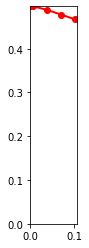

In [4]:
points_output = PointsOutput(points,system,constant_values = system.constant_values)
y = points_output.calc(states,t)
final = numpy.asarray(states[-1,:])
time1 = time.time()
points_output.animate(fps = 30,movie_name = str(time1)+'video_1.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [5]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())